# Conditional GAN (cGAN)

We have tried:
- Simple GAN
- Conditional GAN (cGAN)
  - Different size of FC
  - Different EPOCH
  - Different learning rate
  - Different batch size

We need to try:
- Conditional Deep Convolutional GAN (cDCGAN)
- Make the generated image have more details

In [180]:
# -*- coding: utf-8 -*-
from torchvision import transforms
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from sklearn.manifold import TSNE
from time import time
import copy
import seaborn as sns

torch.__version__

torch.manual_seed(42)

trainPath = './fashion-mnist/train.csv' # Path of data
testPath = './fashion-mnist/test.csv' # Path of data

labelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 64

learning_rate = 0.0001

In [181]:
class Sample:
    def __init__(self, idx=0, img=None, feat = None, label=None):
        self.idx = idx
        self.img = img
        self.feat = feat
        self.label = label
        
def loadImage(inPath):
    samples = []
    dataCsv = pd.read_csv(inPath)
    dataCsvImg = dataCsv.drop(columns = 'label')
    dataCsvImg = dataCsvImg.values.astype('uint8')
    
    images = dataCsvImg.reshape(-1, 28, 28)
    labels = dataCsv['label'].values
    
    for i in range (len(images)):
        sample = Sample(idx=i, img=images[i], feat = dataCsvImg[i], label=labels[i])
        samples.append(sample)
    return samples, images, labels

trainSamples, trainImages, trainLabels = loadImage(trainPath)
testSamples, testImages, testLabels = loadImage(testPath)


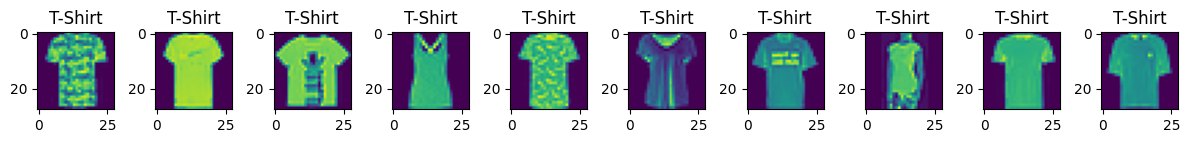

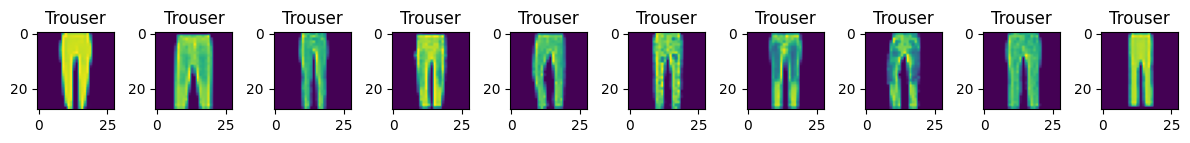

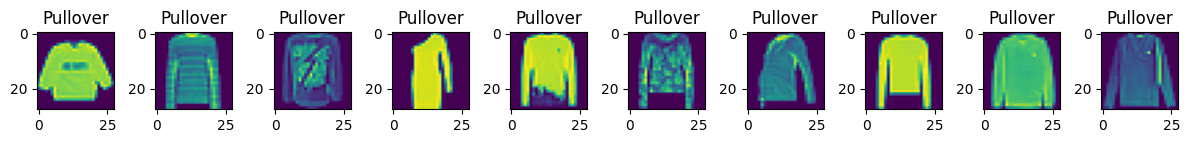

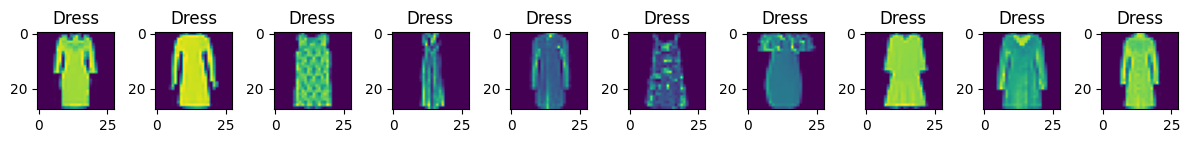

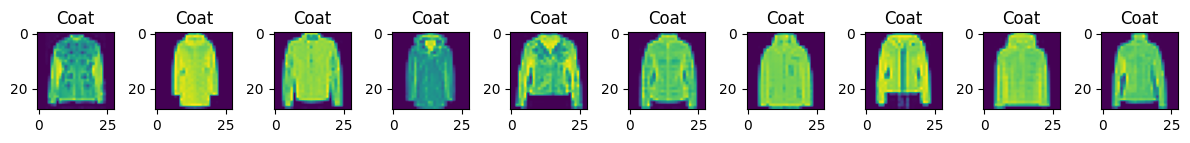

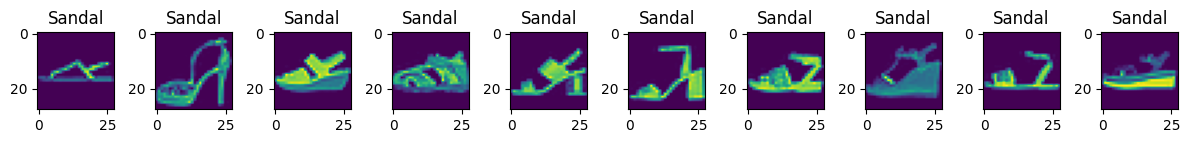

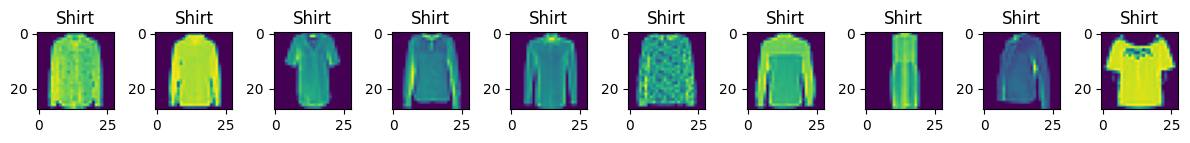

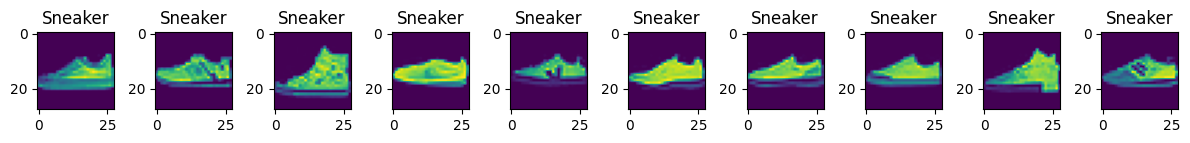

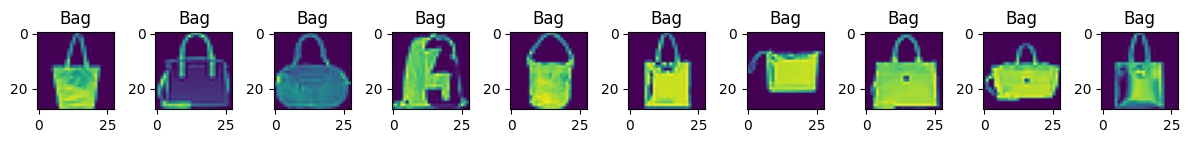

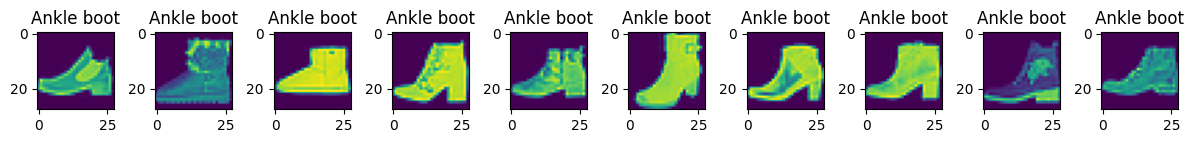

In [182]:
# Task 1: Preprocess the fashion image dataset and visualize some example images.
for l in range(10):
    count = 0
    for sample in trainSamples:
        if int(sample.label) == l:
            if count%10 == 0:
                plt.figure(figsize=(15, 1))
            plt.subplot(1, 10, count%10+1)
            plt.title(labelMap[int(l)])
            plt.imshow(sample.img)
            count += 1
            if (count >= 10):
                break


In [183]:
class FashionDataset(Dataset):
    def __init__(self, inImages, inLabels, transform=None):
        self.transform = transform
        self.images = inImages
        self.labels = inLabels
       
    def __len__(self):
       return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(Image.fromarray(self.images[idx]))
        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

train = FashionDataset(trainImages, trainLabels, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = FashionDataset(testImages, testLabels, transform = transform)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


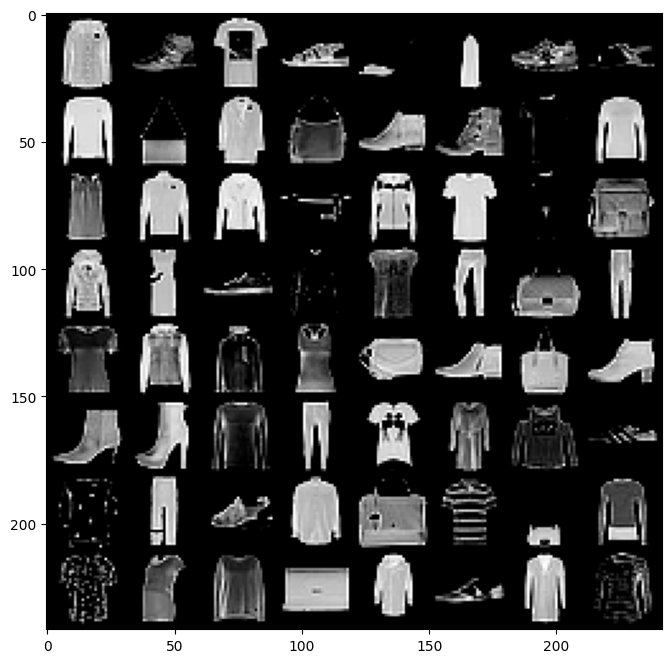

In [66]:
# ## functions to show an image
# def imshow(img):
#     npimg = img.numpy()
#     plt.figure(figsize=(8,8))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# ## get some random training images
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# ## show images
# imshow(make_grid(images[0:64],nrow=8))

In [184]:
# construct 

# layerSize = [32, 64, 128]
# layerSize = [64, 128, 256]
# layerSize = [128, 256, 512]
layerSize = [256, 512, 1024]


class generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Embedding(10, 10)
        
        self.dense0 = nn.Linear(100+10, layerSize[0]) #receive a vector of 100 numbers random + 10 for labels
        self.dense1 = nn.Linear(layerSize[0], layerSize[1])
        self.dense2 = nn.Linear(layerSize[1], layerSize[2])
        self.dense3 = nn.Linear(layerSize[2], 784)
        self.dropout = nn.Dropout(0.3)


    def forward(self, X, labels):
        # append labels to X
        X = X.view(X.shape[0], 100)
        L = self.label_layer(labels)
        X = torch.cat([X, L], dim = 1)

        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))# leaky_relu (value * factor)
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = torch.tanh(self.dense3(X)) # literature 
        X = X.view(X.shape[0], 28, 28) # convert to image (matrix)
        return X

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Embedding(10, 10)
        
        self.dense0 = nn.Linear(784+10, layerSize[2]) #28*28 + 10 for labels 
        self.dense1 = nn.Linear(layerSize[2], layerSize[1])
        self.dense2 = nn.Linear(layerSize[1], layerSize[0])
        self.dense3 = nn.Linear(layerSize[0], 1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, X, labels):
        X = X.view(X.shape[0], 28*28)
        
        L = self.label_layer(labels)    
        
        X = torch.cat([X, L], dim = 1)
        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = self.dense3(X)
        # X = torch.sigmoid(X)
        # X = X.squeeze()
        return X

In [123]:
G = generator()
D = discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = optim.Adam(D.parameters(), lr = learning_rate)

criterion = nn.BCEWithLogitsLoss() # combine sigmoid with and BCELoss

# device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device = torch.device('mps') # for M1 Apple Silicon

G.to(device)
D.to(device)

discriminator(
  (label_layer): Embedding(10, 10)
  (dense0): Linear(in_features=794, out_features=1024, bias=True)
  (dense1): Linear(in_features=1024, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [108]:
# compute D accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    print(logit,logit.shape)
    print(target, target.shape)
    # corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    corrects = (logit.data >= target*0.9).sum()
    accuracy = corrects/batch_size
    return accuracy.item()

def D_accuracy(inD):
    # D Test Accuracy
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = inD.forward(images, labels)
        target = torch.ones(64)
        test_acc += get_accuracy(outputs, target,  batch_size)
    # print('Model Test Accuracy: %.2f'%( test_acc/i))
    return test_acc/i

EPOCH 001 finalized: discriminator loss, accuracy 0.000334 0.000000 - gererator loss 0.004614      


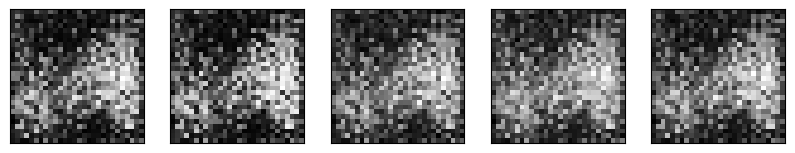

EPOCH 002 finalized: discriminator loss, accuracy 0.000199 0.000000 - gererator loss 0.003324      


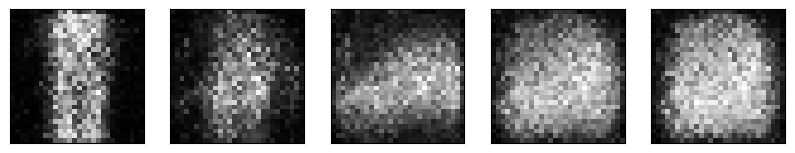

KeyboardInterrupt: 

In [124]:
EPOCH = 10

gLoss = dict()
dLoss = dict()
dAccu = dict()
for epoch in range(EPOCH):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (images_real, labels_real) in enumerate(train_loader):
        batch_size = images_real.size(0)
        # images_real = images_real * 2 - 1
        images_real = images_real.to(device)
        labels_real = labels_real.to(device)


        # ######### Train The Generator #########
        G_optimizer.zero_grad()
        
        random = torch.randn(batch_size, 100).to(device)
        
        # random = np.random.uniform(low=-1., high=1., size=(batch_size, 100))
        # random = torch.from_numpy(random).float().to(device)
        
        random_labels = np.random.uniform(low=0, high=10, size=(batch_size))
        random_labels = torch.from_numpy(random_labels).int().to(device)
        
        images_false = G.forward(random, random_labels)
        output_false = D.forward(images_false, random_labels)
        
        labels_false = torch.ones(batch_size).to(device)
        G_loss = criterion(output_false.view(*labels_false.shape), labels_false)
        # G_loss = criterion(output_false, labels_false)
        G_loss.backward()
        G_optimizer.step()


        # ######### Train The Discriminator #########
        D_optimizer.zero_grad()
        
        # real images
        outputs_real = D.forward(images_real, labels_real)
        # labels_real_false = (torch.ones(batch_size) * 0.9).to(device)
        labels_real_false = (torch.ones(batch_size)).to(device)
        D_loss_real = criterion(outputs_real.view(*labels_real_false.shape), labels_real_false)
        # D_loss_real = criterion(outputs_real, labels_real_false)

        # false images
        random = torch.randn(batch_size, 100).to(device)
        
        # random = np.random.uniform(-1., 1., (batch_size, 100))
        # random = torch.from_numpy(random).float().to(device)
        
        random_labels = np.random.uniform(low=0, high=10, size=(batch_size))
        random_labels = torch.from_numpy(random_labels).int().to(device)
        
        images_false = G.forward(random, random_labels)
        outputs_false = D.forward(images_false, random_labels)
        
        labels_false = torch.zeros(batch_size).to(device)
        D_loss_false = criterion(outputs_false.view(*labels_false.shape), labels_false)
        # D_loss_false = criterion(outputs_false, labels_false)

        D_loss = D_loss_real + D_loss_false
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()
        
        D_running_loss /= len(train_loader)
        G_running_loss /= len(train_loader)
        
        gLoss[epoch] = G_running_loss
        dLoss[epoch] = D_running_loss
        

    if (epoch + 1) % 1 == 0:
        # D_running_accuracy = D_accuracy(D)
        # dAccu[epoch] = D_running_accuracy
        D_running_accuracy = 0
        
        # print the loss after each epoch
        print('EPOCH {:03d} finalized: discriminator loss, accuracy {:03.6f} {:03.6f} - gererator loss {:03.6f}      '.format(epoch + 1, D_running_loss, D_running_accuracy, G_running_loss))
        
        # display 10 generated images
        random = torch.randn(10, 100).to(device)
        random_labels = np.array([i for _ in range(1) for i in range(10)])
        random_labels = torch.from_numpy(random_labels).int().to(device)
        output  = G.forward(random, random_labels).unsqueeze(1).data.to(device)
        output = output.view(10, 1, 28, 28)
        grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(grid)
        plt.show()
        # fig, ax = plt.subplots(1, 5, figsize=(10,5))
        # for i in range(5):
        #     ax[i].imshow(images_false.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
        #     ax[i].xaxis.set_visible(False)
        #     ax[i].yaxis.set_visible(False)
        # plt.show()
torch.save(G, 'cGAN_G_256_10.pth')

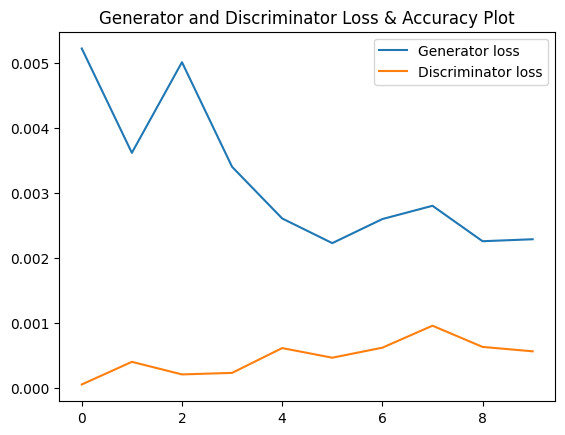

In [78]:
plt.title("Generator and Discriminator Loss & Accuracy Plot")
plt.plot(gLoss.keys(),gLoss.values(), label="Generator loss")
plt.plot(dLoss.keys(),dLoss.values(), label="Discriminator loss")
# plt.plot(dAccu.keys(),dAccu.values(), label="Discriminator accuracy")
plt.legend()
plt.show()

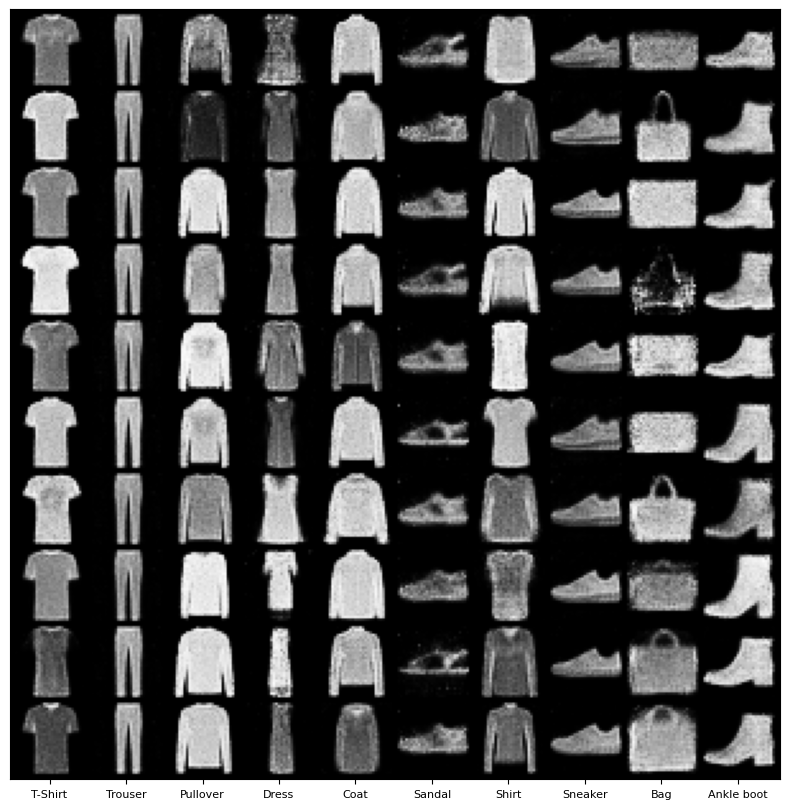

In [185]:
G = torch.load('GAN_saved_models/cGAN/cGAN_G_256_300.pth')
# random = np.random.uniform(-1., 1., (100,100))
# random = torch.from_numpy(random).float().to(device)

random = torch.randn(100, 100).to(device)

# random_labels = np.array([i for _ in range(10) for i in [3]*10])

random_labels = np.array([i for _ in range(10) for i in range(10)])
random_labels = torch.from_numpy(random_labels).int().to(device)

G.eval()
output  = G.forward(random, random_labels).unsqueeze(1).data.to(device)
# output = output.cpu().detach().numpy()

# Show images
grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
a = plt.yticks([])
b = plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)


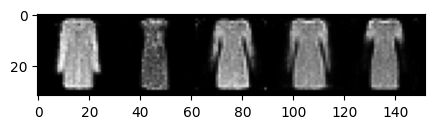

In [187]:
# generate images from a label
def generateFromLabel(inG, inLabel, inNum):
    random = torch.randn(inNum, 100).to(device)
    random_labels = np.array([i for _ in range(1) for i in [inLabel]*inNum])
    random_labels = torch.from_numpy(random_labels).int().to(device)
    inG.eval()
    output  = inG.forward(random, random_labels).unsqueeze(1).data.to(device)
    grid = make_grid(output, nrow=inNum, normalize=True).permute(1,2,0).numpy()
    fig, ax = plt.subplots(figsize=(inNum,inNum))
    ax.imshow(grid)

generateFromLabel(G, 3, 10)

<BarContainer object of 10 artists>

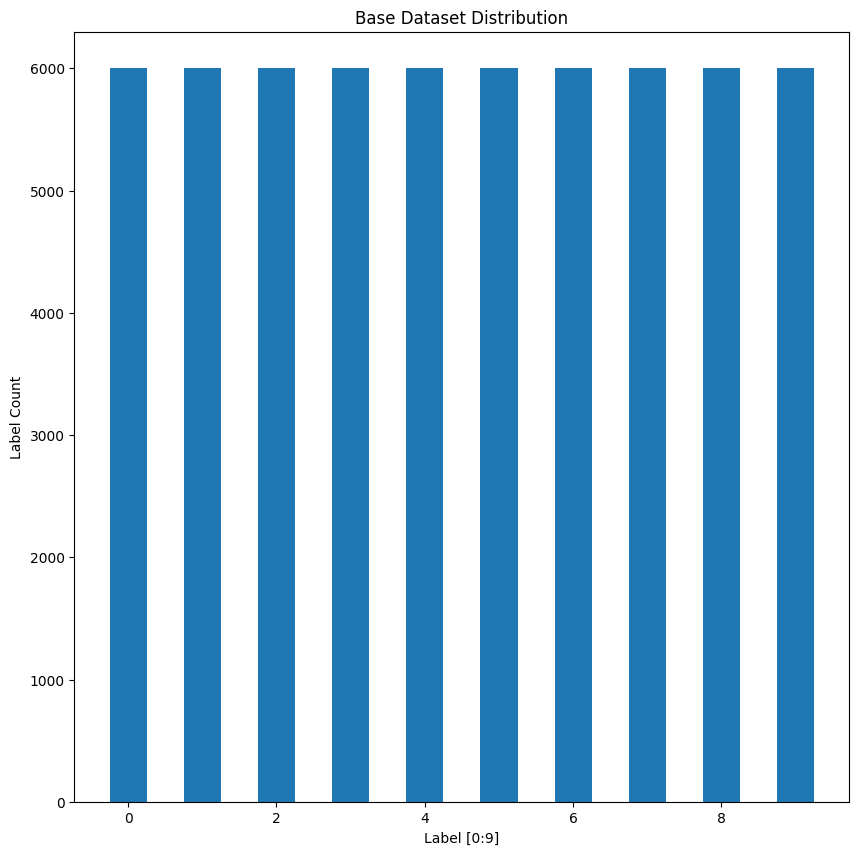

In [105]:
# Visualizations
labels = [sample.label for sample in trainSamples]
keys = Counter(labels).keys()
counts = Counter(labels).values()
plt.figure(figsize=(10, 10))
plt.title("Base Dataset Distribution")
plt.xlabel("Label [0:9]")
plt.ylabel("Label Count")
plt.bar(Counter(labels).keys(),Counter(labels).values(),width=0.5)

Computing t-SNE embedding


<Figure size 2000x2000 with 0 Axes>

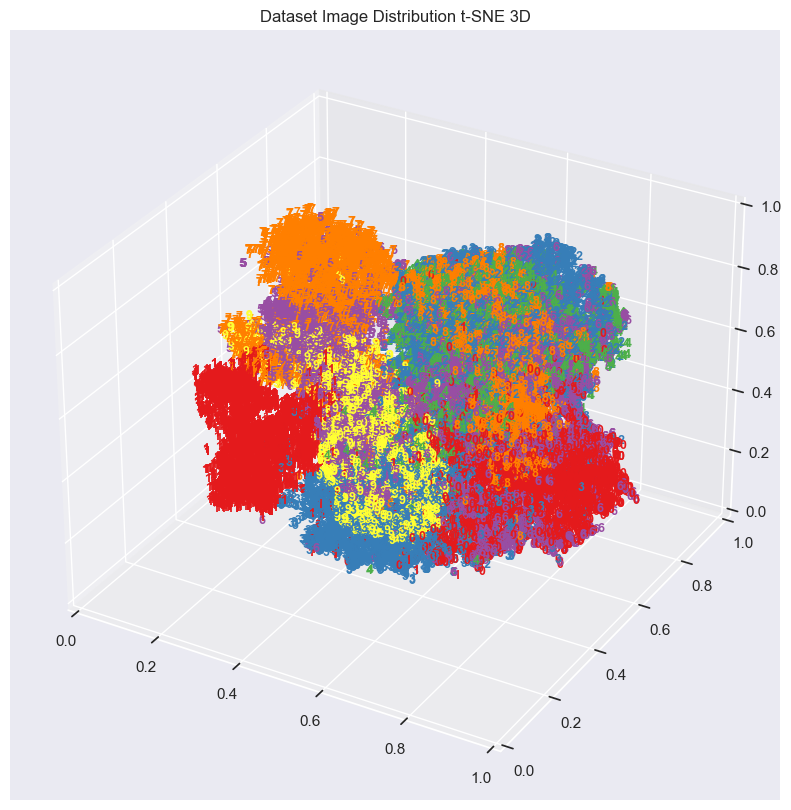

In [109]:
# check data image 3D distribution with t-NSE
X = np.array([sample.feat for sample in trainSamples])
y = [sample.label for sample in trainSamples]

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X)
X_tsne = tsne.fit_transform(X)

def plot_embedding_3d(X, title=None):
    plt.figure(figsize=(20, 20))    
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]), color=plt.cm.Set1(y[i] / 15.), fontdict={'weight': 'bold', 'size': 9})
        if title is not None:
            plt.title(title)

plot_embedding_3d(X_tsne,"Dataset Image Distribution t-SNE 3D")

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_84140/1049182640.py:12: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')


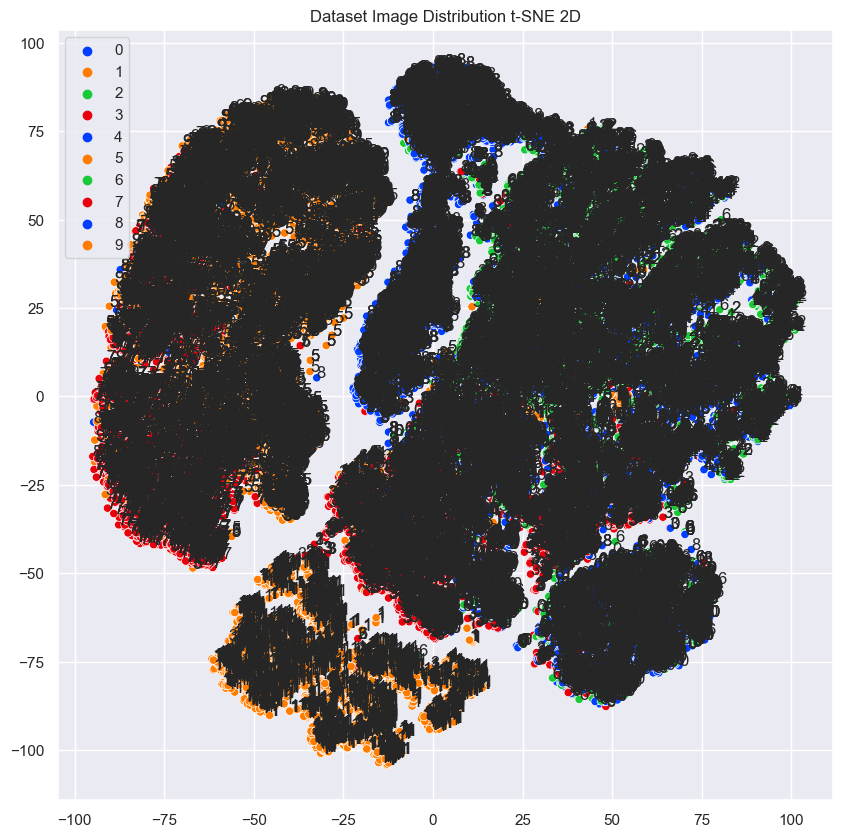

In [107]:
# check dataset pixcel feature 2D distribution with t-NSE

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("bright", 4) 

features = np.array([sample.feat for sample in trainSamples])
labels = [sample.label for sample in trainSamples]
ids = [(sample.label) for sample in trainSamples]

tsne = TSNE() 
X_embedded = tsne.fit_transform(features)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')
# for i, (x, y) in enumerate(X_embedded):
#     plt.text(x, y, ids[i])

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_84140/2539749196.py:1: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')


[Text(0.5, 1.0, 'Dataset Image Distribution t-SNE 2D')]

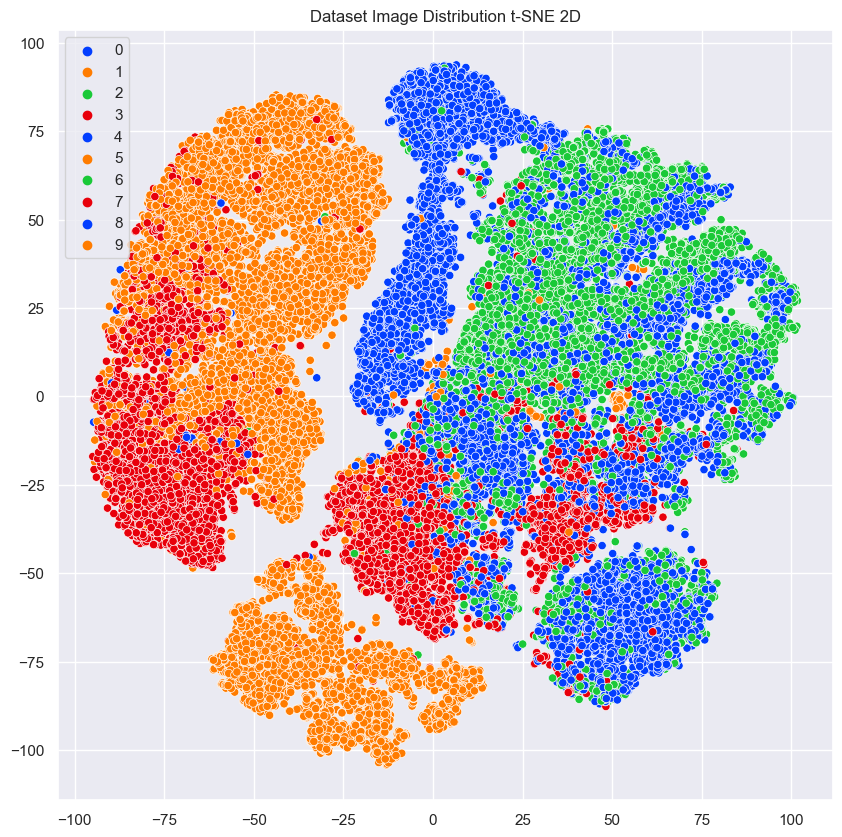

In [108]:
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')